<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/Salary_Prediction_text_classification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Salary Prediction (NLP - text classification)


https://www.kaggle.com/competitions/job-salary-prediction

In [53]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

In [54]:
%matplotlib inline

In [2]:
%%capture
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip

data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)

In [3]:
data.shape

(244768, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [5]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


### Drop unnecessary data

In [40]:
df = data.drop(['Id', 'LocationRaw', 'SalaryRaw', 'SourceName', 'SalaryNormalized'], axis=1)
df = df.rename(columns={'LocationNormalized':'Location'})

### Create target column with log of salary to mtigate a huge salary gap which is a result of social inequality. That would help is we want to minimize MSE.

In [41]:
df['SalaryLog'] = np.log1p(data['SalaryNormalized']).astype('float32')

### Fill empty values

(better do that before converting object to category)

In [42]:
df['Title'] = df['Title'].fillna('quality improvement manager')
df = df.fillna('NaN')

### Group columns by purpose

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Title            244768 non-null  object 
 1   FullDescription  244768 non-null  object 
 2   Location         244768 non-null  object 
 3   ContractType     244768 non-null  object 
 4   ContractTime     244768 non-null  object 
 5   Company          244768 non-null  object 
 6   Category         244768 non-null  object 
 7   SalaryLog        244768 non-null  float32
dtypes: float32(1), object(7)
memory usage: 14.0+ MB


In [43]:
TARGET = 'SalaryLog'
TEXT_COLS = ['Title', 'FullDescription']
CATEGORIES = ['FullDescription', 'Location', 'ContractType', 'ContractTime', 'Company', 'Category']

## Create tokenizer and tokenize features

In [44]:
WPT = nltk.tokenize.WordPunctTokenizer()

In [49]:
tok_df = df.copy()
for col in TEXT_COLS:
  tok_df[col] = tok_df[col].apply(lambda x: ' '.join(WPT.tokenize(x.lower())))

### Bathe in tests

In [51]:
print("Tokenized:")
print(tok_df["FullDescription"][2::100000])
assert tok_df["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert tok_df["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


## Create an approved list of known word

In [ ]:
token_nums = Counter()

for col in TEXT_COLS:
  for row in tok_df[col]:
    token = row.split()
    token_nums.update(token)

### Bathe in tests

In [59]:
print("Total unique tokens :", len(token_nums))
print('\n'.join(map(str, token_nums.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_nums.most_common()[-3:])))

assert token_nums.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_nums) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


#### Word frequency histogram

Text(0.5, 0, 'Word counts')

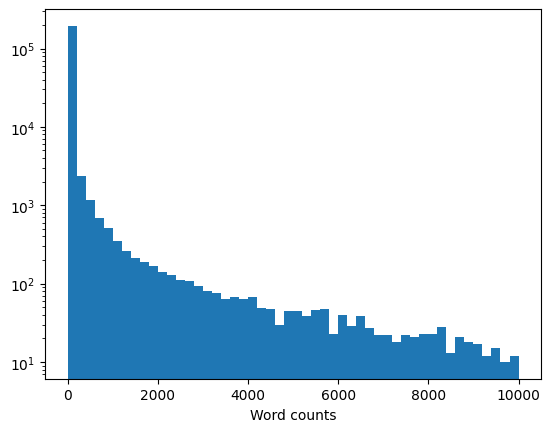

In [61]:
plt.hist(list(token_nums.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")

#### We clearly don't need words that occur once or twice in the whole text corpus. So let's filter them

## Create a list of "approved" tokens as well as "padding" token for short sentences and "unknown" token for words we cut out/haven't encountered in the trainset

In [68]:
UNK, PAD = "UNK", "PAD"
min_count = 10
tokens = [UNK, PAD] + sorted(t for t, c in token_nums.items() if c >= min_count)

### Bathe in tests

In [69]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


### Convert data types for faster df operations

In [37]:
'''
converted_df = tok_df.copy()
for column in converted_df.columns:
  if converted_df[column].dtype == 'object':
    converted_df[column] = converted_df[column].astype('category')'''

Somehow converting string 'object' types to 'category' breaks the followng code creating issues with assigning new values (since category values should be predefined) and using .apply() so for now we're not gonna use it and are going to convert objeto to category right before feeding the dataset to the model.